In [2]:
!pip install pandas
!pip install pysmiles
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from pysmiles import read_smiles

# TD / TP -- Discriminant graph mining

The objective of this TD is to implement a DFS algorithm to mine discriminant molecule graphs. 
We will more specifically investigate the question of Blood Brain Barrier (BBB) traversal. The BBB prevents large molecules in the blood to penetrate the brain. 
Knowing whether a candidate drug is capable to go through the BBB is essential to design drugs again brain diseases. 
Then, there are many research effort to predict whether a molecule (candidate drug) can cross the BBB.

In this TP, we will use a discriminant graph mining technique. 

The TP is organized in three parts :
1. you will discover a bit more the data and the library that we propose to use to manipulate molecules
2. you will implement a frequent graph mining algorithm. As we have already seen, the problem with graphs is that there are potentially a lot of redundancies: you will do your best to address this issue.
3. you will implement an disciminant graph mining approach

### Discovery of the data and the library

#### Molecule data as a graph

In [4]:
#load dataset
!wget https://github.com/theochem/B3DB/blob/main/B3DB/B3DB_classification.tsv

--2023-02-20 15:44:02--  https://github.com/theochem/B3DB/blob/main/B3DB/B3DB_classification.tsv
Résolution de github.com (github.com)… 140.82.121.3
Connexion à github.com (github.com)|140.82.121.3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : non indiqué [text/html]
Enregistre : ‘B3DB_classification.tsv.2’

B3DB_classification     [ <=>                ] 133,80K  --.-KB/s    ds 0,1s    

2023-02-20 15:44:03 (1,32 MB/s) - ‘B3DB_classification.tsv.2’ enregistré [137014]



In [5]:
classification_data = pd.read_csv("B3DB_classification.tsv",sep="\t")
#we keep only to attributes: 
# - SMILES: the textual description of a molecule
# - BBB+/BBB-: the class
classification_data=classification_data[['SMILES','BBB+/BBB-']]
classification_data

SMILES BBB+/BBB-
0      O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      BBB-
1     COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      BBB-
2                                Oc1c(I)cc(Cl)c2cccnc12      BBB-
3                            CCNC(=NCCSCc1ncccc1Br)NC#N      BBB-
4     CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...      BBB-
...                                                 ...       ...
7802                    c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1      BBB-
7803                   CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21      BBB+
7804               CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1      BBB+
7805                     Cc1[nH]c(=O)c(C#N)cc1-c1ccncc1      BBB-
7806                          Nc1cc(-c2ccncc2)c[nH]c1=O      BBB-

[7807 rows x 2 columns]

In [6]:
# the SMILES of a molecule is its textual description (it is not unique!). 
smiles=classification_data['SMILES'].iloc[0]
smiles

'O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O'

In [7]:
# we use the pySMILES library to automatically build a graph (represented with the NXGraph library) from the SMILES description.
# In the following we will only consider the labels on the vertex, but not on the edges (double-linkage or simple linkage).
# Note that the construction of the graph may also discard stereochemical information. We will then ignore this information.
 
mol = read_smiles(smiles)
print(mol)
print(mol.nodes(data='element'))
print(mol.edges())

Graph with 28 nodes and 30 edges
[(0, 'O'), (1, 'C'), (2, 'O'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'N'), (7, 'N'), (8, 'C'), (9, 'C'), (10, 'C'), (11, 'C'), (12, 'S'), (13, 'O'), (14, 'O'), (15, 'N'), (16, 'C'), (17, 'C'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'N'), (22, 'C'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C'), (27, 'O')]
[(0, 1), (1, 2), (1, 3), (3, 4), (3, 26), (4, 5), (5, 6), (5, 24), (6, 7), (7, 8), (8, 9), (8, 23), (9, 10), (10, 11), (11, 12), (11, 22), (12, 13), (12, 14), (12, 15), (15, 16), (16, 17), (16, 21), (17, 18), (18, 19), (19, 20), (20, 21), (22, 23), (24, 25), (25, 26), (26, 27)]


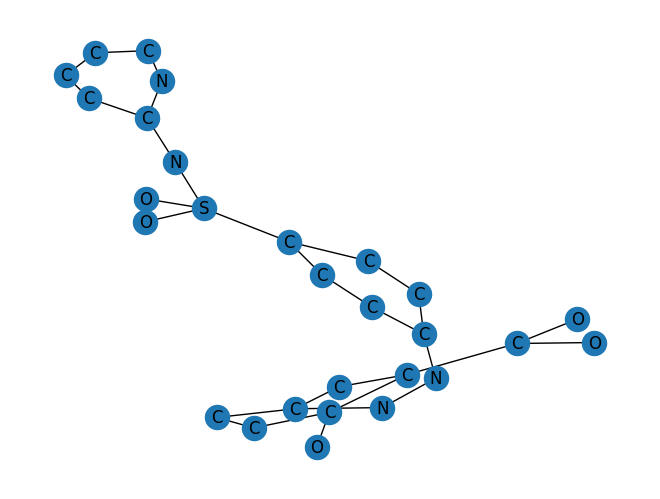

In [8]:
#we define a draw_mol function to easily visualize the molecule graphs

def draw_mol(mol):
    elements = nx.get_node_attributes(mol, name = "element")
    nx.draw(mol,with_labels = True, labels=elements)


draw_mol(mol)

In [9]:
# then ... we can transform the dataframe above into a dataset of molecules
dataset=[]
classes=[]
#for i in range(len(classification_data)):
for i in range(1350,1450): #we take only 100 graphs for testing more efficiently our methods (this can be changed at the end). The location has been choosen to have a balance set of positive and negative examples.
    dataset.append( read_smiles(classification_data.iloc[i]['SMILES']) )
    classes.append( 1 if classification_data.iloc[i]['BBB+/BBB-']=='BBB+' else 0  )

print( sum(classes) )

Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical informat

68


#### Manipulating graphs with the NetworkX library

The NetworkX (NX) library is a powerfull library to manage and manipulate graphs in Python. 
We use it because it provides an efficient implementation of subgraph isomorphism test. 
Implementing such function by our own will be cumbersome and not efficient!


In [10]:
#create a graph from scratch
pattern=nx.Graph()
# add a vertex with index 0 and label 'C'. Vertex (and edges) can be multi labeled, for this 
# reason we have to precise "element=" to specify that we provide a label of the attribute "element"
# of the vertex. This attribute name is the one choosed by pySMILES
pattern.add_node(0,element='N')
pattern.add_node(1,element='O')
# add an edge from node 0 to node 1
pattern.add_edge(0,1)

# indices are unique -> the following line will "replace" the label of the node 0
pattern.add_node(0,element='C')

In [11]:
# have a look at your graph
print(pattern.nodes(data='element'))
print(pattern.edges())

[(0, 'C'), (1, 'O')]
[(0, 1)]


In [12]:
## Creation of an isomorphic graph and test the isomorphism with NX
pattern_iso=nx.Graph()
pattern_iso.add_node(0,element='O')
pattern_iso.add_node(1,element='S')
pattern_iso.add_edge(0,1)
#NB: `pattern_iso` is not isomorphic to `pattern` because of the labels!

#simply test the isomorphism between the two graphs' structures: it does not take into account the labels
isiso=nx.isomorphism.is_isomorphic(pattern,pattern_iso)
print(isiso)

# we have to add an additional matching function for nodes (look at the documentation of NX for more details)
isiso=nx.isomorphism.is_isomorphic(pattern, pattern_iso, node_match=nx.isomorphism.categorical_node_match("element", ""))
print(isiso)

pattern_iso.add_node(1,element='C')
#NB: `pattern_iso` is now isomorphic to `pattern`
isiso=nx.isomorphism.is_isomorphic(pattern, pattern_iso, node_match=nx.isomorphism.categorical_node_match("element", ""))
print(isiso)

True
False
True


In [13]:
# NX: subgraph isomorphism test
# The following line illustrates how to test whether the `pattern` occurs in the molecule.
matches=nx.isomorphism.GraphMatcher(mol,pattern, node_match=nx.isomorphism.categorical_node_match("element", "")).subgraph_is_isomorphic()
print(matches)

# add a new node
pattern.add_node(2,element='S')
pattern.add_edge(1,2)
matches=nx.isomorphism.GraphMatcher(mol,pattern, node_match=nx.isomorphism.categorical_node_match("element", "")).subgraph_is_isomorphic()
print(matches)


True
False


### Frequent graph mining algorithm

In [14]:
nodes_vocabulary = ['O', 'N', 'C', 'S', 'H']

**Q1.** Implement a function that returns a boolean vector indicating the matches of a pattern with each dataset elements

In [15]:
def support(dataset, pattern):
    """evaluate the support of the pattern on the dataset"""
    matches = [nx.isomorphism.GraphMatcher(mol, pattern, node_match=nx.isomorphism.categorical_node_match("element", "")).subgraph_is_isomorphic() for mol in dataset]
    return matches

#test the function
p=nx.Graph()
p.add_node(0,element='O')
p.add_node(1,element='C')
p.add_node(2,element='C')
p.add_edge(0,1)
p.add_edge(1,2)
supp=support(dataset,p)
print(sum(supp)) #expected result: 96
#supp

96


**Q2.** Implement a function that checked whether a graph-pattern occurs in a list of graph patterns

In [16]:
def exists(g, patterns):
    """test if the graph `g` exists in the list of `patterns` """
    for gp in patterns:
        if nx.isomorphism.is_isomorphic(g, gp, node_match=nx.isomorphism.categorical_node_match("element", "")):
            return True
    return False

**Q3.** Defines all possible extensions of a graph and then implement a function that evaluates the support of a pattern and continue the exploration (until the pattern is unfrequent or reach a maximum size $m$).

The objective of this question is just to create a first version of the space exploration without any consideration of redundant exploration.

In [17]:
def extend(g, dataset, sigma, fpatterns, m=5):
    """Recursive pattern extention 
    g: the current graph pattern
    dataset: list of graphs
    sigma: minimal frequency threshold
    fpatterns: (in/out) list of the current frequent patterns (not elegant ... but a bit simpler)
    m: maximum size of the graph
    
    The function does not return anything ... it uses the fpattern list as an in/out parameter
    """
    if len(g.nodes())>m: #this pattern is too large
        return
    #compute the support of $g$
    supp = support(dataset, g)
    if len(supp)<sigma: #the pattern is not frequent: anti-monotonicity, we stop the search
        return
    
    #HERE: the pattern is new, not redundant and satisfy the size constraint: we add it to the fpatterns
    fpatterns.append(g)

    # we now investigate the subpart of the search space

    ## add an edge on the existing nodes
    nbnodes = len(g.nodes())
    for i in range(nbnodes):
        for j in range(i+1,nbnodes):
            if not (i,j) in g.edges():
                g_extend = g.copy()
                g_extend.add_edge(i,j)
                extend(g_extend, dataset, sigma, fpatterns, m)
    
    # add an atom to the graph connected to node i (without edge)
    for i in range(nbnodes):
        for A in nodes_vocabulary:
            g_extend = g.copy()
            g_extend.add_node(nbnodes,element=A)
            g_extend.add_edge(i,nbnodes)
            extend(g_extend, dataset, sigma, fpatterns, m)

In [18]:
def mine(dataset, sigma, m):
    """Recursive pattern extension 

    dataset: list of graphs
    sigma: minimal frequency threshold
    m: maximum size of the graph

    return a list of of frequent graph-patterns
    """

    fpatterns=[]

    for A in nodes_vocabulary:
        g=nx.Graph()
        g.add_node(0,element=A)
        extend(g, dataset, sigma, fpatterns, m)
    return fpatterns
    

In [19]:
# a small example (be careful with m ... keep it very small)
graphs = mine(dataset, 50, 3)

In [20]:
print(len(graphs))

530


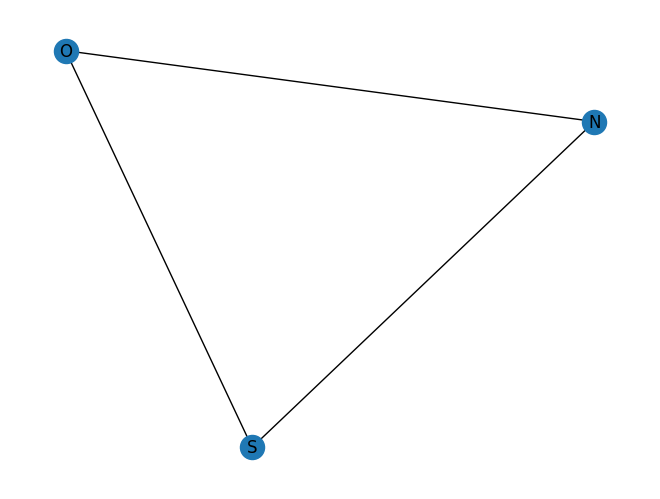

In [21]:
draw_mol(graphs[30]) 

**Q4.** what is the maximum depth of the recursion for your algorithm?

**Q5.** Implement an optimized version of the `extend` function:
1. add a test to check whether a graph is already known as a frequent graph (use the `exists` function)
2. add a technique of database projection to reduce the number of subgraph isomorphism test: instead of using the complete dataset in the recursion call, you can only use the graphs that contains the current graph `g`
3. precompute a list of frequent edges to reduce the number of extensions to evaluate
4. define strategy inspired by the technic of letic orders to prevent a priori from redundant searches.

For each version of your code, you can compare the execution times and the number of outputs to highlight the improvements.

_Warning:_ Please note that the implementation of DFS code is a bit technical. For an actually efficient graph mining algorithm, we invite you to have look at the strategies and existing implementations of gSpan or Gaston.

In [22]:
def extend(g, dataset, sigma, fpatterns, m=5):
    """Recursive pattern extension 
    g: the current graph pattern
    dataset: list of graphs
    sigma: minimal frequency threshold
    fpatterns: (in/out) list of the current frequent patterns
    m: maximum size of the graph
    
    The function does not return anything ... it uses the fpattern list as an in/out parameter
    """
    if len(g.nodes())>m: #this pattern is too large
        return
    if exists(g,fpatterns): #this pattern is frequent but it has already been explored
        return
    #compute the support of $g$
    supp = support(dataset, g)
    if len(supp)<sigma: #the pattern is not frequent: anti-monotonicity, we stop the search
        return
    
    #HERE: the pattern is new, not redundant and satisfy the size constraint: we add it to the fpatterns
    fpatterns.append(g)

    #dataset projection -> will prevent from too much subgraph isomorphism test
    dataset_extend = [dataset[i] for i in range(len(dataset)) if supp[i]]

    # we now investigate the subpart of the search space

    ## add an edge on the existing nodes
    nbnodes = len(g.nodes())
    for i in range(nbnodes):
        for j in range(i+1,nbnodes):
            if not (i,j) in g.edges():
                g_extend = g.copy()
                g_extend.add_edge(i,j)
                extend(g_extend, dataset_extend, sigma, fpatterns, m)
    
    # add an atom to the graph connected to node i (without edge)
    for i in range(nbnodes):
        for A in nodes_vocabulary:
            g_extend = g.copy()
            g_extend.add_node(nbnodes,element=A)
            g_extend.add_edge(i,nbnodes)
            extend(g_extend, dataset_extend, sigma, fpatterns, m)

In [23]:
# a small example (be careful with m ... keep it very small)
graphs = mine(dataset, 50, 3)

In [24]:
print(len(graphs))

43


### Discriminant pattern mining

In this section, the objective is to investigate the mining of discriminant graphs, ie graphs that occur more likely in molecules that cross the BBB.

For that, we start by proposing a simple algorithm which consists in extracting the frequent graphs that are discriminant.

We propose to use the growth rate ($GR$) to define a discrimant pattern. More specifically, a graph is said to be discriminant if its growth rate is above a user defined threshold $\mu$, where the growth rate is defined as follows
$$gr_\mathcal{D}(p) = \left\{ \begin{array}{ll} 0 & \text{if } supp_{\mathcal{D}^+}(p) = supp_{\mathcal{D}^-}(p) = 0 \\
+\infty &  \text{if } supp_{\mathcal{D}^+}(p) \neq 0 \wedge supp_{\mathcal{D}^-}(p) = 0 \\ 
\frac{supp_{\mathcal{D}^+}(p)}{supp_{\mathcal{D}^-}(p))} &  \text{otherwise } \end{array}\right.$$

where $\mathcal{D}^+$ (resp. $\mathcal{D}^-$) denotes the set of positive (resp. negative) examples.

Notes that there are several alternatives to this measure. This one is simple and, contrary to the accuracy, it prevents from having too much patterns with low support. Indeed, graphs patterns with low support will have more likely high accuracy.

</br>

The approach we propose to extract discriminant graph patterns is to extract 
$$ \{ g \,\mid\, supp_{\mathcal{D}^+}(p)\geq \sigma \wedge gr_\mathcal{D}(p)\geq \mu\}$$
where $\sigma\in\mathbb{N}_+$ and $\mu\in\mathbb{R}^+$ are two used defined thresholds.

Then,, we propose the following algorithm:
1. mine the frequent graphs in $\mathcal{D}^+$
2. for each frequent graph $g$, discard the ones that have a growth rate lower than $\mu$

**Q6.** Implement the proposed strategy

In [25]:
def gr(p,d_plus,d_moins):
    s_plus = len(support(d_plus,p))
    s_moins = len(support(d_moins,p))
    if s_plus==0 and s_moins==0:
        return 0
    if s_moins==0:
        return float("inf")
    return float(s_plus)/float(s_moins)

In [26]:
def emerging_patterns(dataset, classes, sigma, mu, m):
    fgraphs = mine(dataset, sigma, m)
    dp = [g for idx,g in enumerate(dataset) if classes[idx]]
    dm = [g for idx,g in enumerate(dataset) if not classes[idx]]
    return [g for g in fgraphs  if gr(g,dp,dm)>mu]

In [27]:
egraphs=emerging_patterns(dataset, classes, 50, 2.0, 4)
len(egraphs)

106

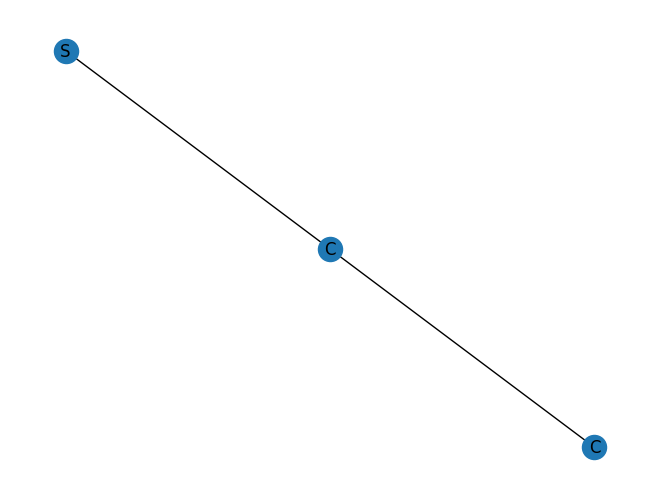

In [28]:
draw_mol(egraphs[100])

**Q7.** identify the graph patterns of size at most 4 with $\sigma=100$ and $\mu=2.0$ for the 2000-th first molecule of the dataset

In [29]:
# then ... we can transform the dataframe above into a dataset of molecules
dataset=[]
classes=[]
for i in range(0,2000):
    dataset.append( read_smiles(classification_data.iloc[i]['SMILES']) )
    classes.append( 1 if classification_data.iloc[i]['BBB+/BBB-']=='BBB+' else 0  )

print( sum(classes) )

Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information that will be discarded.
Atom "[C@H]" contains stereochemical information that will be discarded.
Atom "[C@@H]" contains stereochemical information 

1649


In [30]:
egraphs=emerging_patterns(dataset, classes, 100, 2.0, 4)
len(egraphs)

234

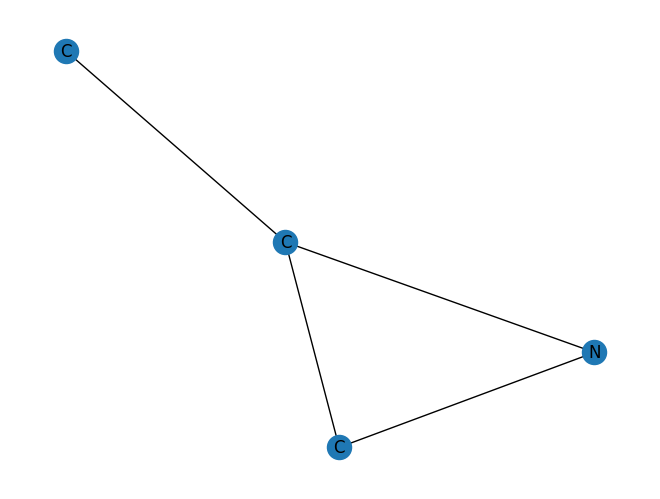

In [31]:
draw_mol(egraphs[140])

As a concluding remark ... we invite you to think about how to make prediction with these outputs ...